In [1]:
import os
import json
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
from sklearn.metrics import precision_recall_fscore_support
from Levenshtein import distance as levenshtein_distance
from ultralytics import YOLO
#import easyocr
import logging
import pytesseract
import editdistance
from tabulate import tabulate
import random

In [2]:
# Constants
DATA_DIR = 'TextOCR/train_val_images/train_images'
ANNOT_PATH = 'TextOCR/annot.csv'
IMAGE_OUTPUT_DIR = 'dataset/images'
LABEL_OUTPUT_DIR = 'dataset/labels'
SUBSET_RATIO = 0.02

# Prepare directories
def prepare_directories(image_output_dir, label_output_dir):
    os.makedirs(image_output_dir, exist_ok=True)
    os.makedirs(label_output_dir, exist_ok=True)
    print(f"Directories created at {image_output_dir} and {label_output_dir}")

# Create directories for images and labels
prepare_directories(IMAGE_OUTPUT_DIR, LABEL_OUTPUT_DIR)


Directories created at dataset/images and dataset/labels


In [3]:
# Function to split and reduce dataset size
def reduce_dataset_size(image_ids, subset_ratio=0.02):
    train_ids, test_ids = train_test_split(image_ids, test_size=0.03, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)
    small_train_ids, _ = train_test_split(train_ids, test_size=1-subset_ratio, random_state=42)
    small_val_ids, _ = train_test_split(val_ids, test_size=1-subset_ratio, random_state=42)
    small_test_ids, _ = train_test_split(test_ids, test_size=1-subset_ratio, random_state=42)
    return small_train_ids, small_val_ids, small_test_ids

# Load and split data
annot_df = pd.read_csv(ANNOT_PATH)
image_ids = annot_df['image_id'].unique()
small_train_ids, small_val_ids, small_test_ids = reduce_dataset_size(image_ids, SUBSET_RATIO)

In [4]:
# Function to convert bounding boxes to YOLO format
def convert_to_yolo_format(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = max(0, min(1, x * dw))
    y = max(0, min(1, y * dh))
    w = max(0, min(1, w * dw))
    h = max(0, min(1, h * dh))
    return (x, y, w, h)
    
# Copy images and create label files in YOLO format
def process_images_and_labels(image_ids, annot_df):
    for image_id in image_ids:
        img_path = os.path.join(DATA_DIR, f'{image_id}.jpg')
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        
        new_img_path = os.path.join(IMAGE_OUTPUT_DIR, f'{image_id}.jpg')
        cv2.imwrite(new_img_path, img)
        
        records = annot_df[annot_df['image_id'] == image_id]
        boxes = records['bbox'].apply(json.loads).tolist()
        boxes = [[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in boxes]
        
        label_file_path = os.path.join(LABEL_OUTPUT_DIR, f'{image_id}.txt')
        with open(label_file_path, 'w') as f:
            for box in boxes:
                yolo_box = convert_to_yolo_format((w, h), box)
                f.write(f'0 {yolo_box[0]} {yolo_box[1]} {yolo_box[2]} {yolo_box[3]}\n')

In [ ]:
# Process images and labels, only run when the dataset folder is not already in place.
#process_images_and_labels(image_ids, annot_df)


In [5]:
# Create the text files listing paths to images
def create_text_file(image_ids, file_path):
    with open(file_path, 'w') as f:
        for image_id in image_ids:
            img_path = os.path.join(os.getcwd(), IMAGE_OUTPUT_DIR, f'{image_id}.jpg')
            f.write(f'{img_path}\n')

In [6]:
create_text_file(small_train_ids, 'dataset/train.txt')
create_text_file(small_val_ids, 'dataset/val.txt')
create_text_file(small_test_ids, 'dataset/test.txt')

print("Text files created successfully.")

Text files created successfully.


In [7]:
class TextOCRDataset(Dataset):
    def __init__(self, image_ids, annot_df, data_dir, transforms=None, target_size=(640, 640)):
        self.image_ids = image_ids
        self.annot_df = annot_df
        self.data_dir = data_dir
        self.transforms = transforms
        self.target_size = target_size

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.data_dir, f'{image_id}.jpg')
        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size

        # Apply transformations
        if self.transforms:
            img = self.transforms(img)

        # Rescale bounding boxes to match the resized image dimensions
        records = self.annot_df[self.annot_df['image_id'] == image_id]
        boxes = records['bbox'].apply(json.loads).tolist()
        boxes = [[b[0] * self.target_size[0] / original_width, 
                  b[1] * self.target_size[1] / original_height,
                  (b[0] + b[2]) * self.target_size[0] / original_width,
                  (b[1] + b[3]) * self.target_size[1] / original_height] for b in boxes]

        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.ones((len(boxes),), dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.image_ids)

# Data Transforms
transform = T.Compose([
    T.Resize((640, 640)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#    T.RandomHorizontalFlip(),
    T.ToTensor()
])


In [8]:
# Data Loaders
small_train_dataset = TextOCRDataset(small_train_ids, annot_df, DATA_DIR, transforms=transform)
val_dataset = TextOCRDataset(small_val_ids, annot_df, DATA_DIR, transforms=transform)
test_dataset = TextOCRDataset(small_test_ids, annot_df, DATA_DIR, transforms=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

small_train_loader = DataLoader(small_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)


In [9]:
# Print dataset sizes to verify reduction
print(f"Training dataset size: {len(small_train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 337
Validation dataset size: 84
Test dataset size: 13


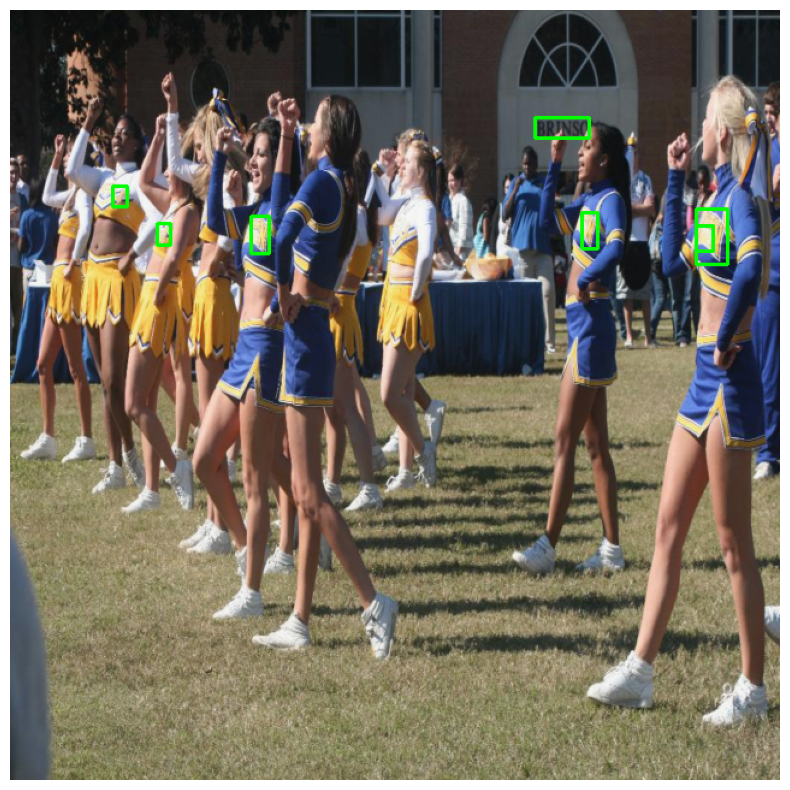

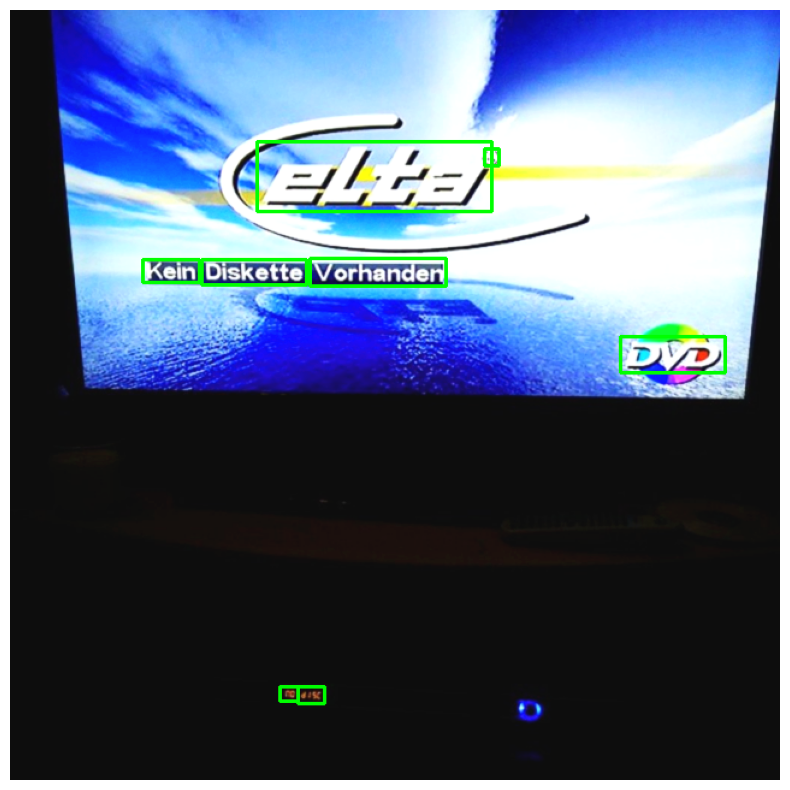

In [11]:
def visualize_data(dataset, idx=0, color=(0, 255, 0), thickness=2, figsize=(10, 10)):
    img, target = dataset[idx]
    boxes = target['boxes'].cpu().numpy()
    img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.ascontiguousarray(img)

    # Draw bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Visualize some training data
visualize_data(small_train_dataset, idx=0)
visualize_data(small_train_dataset, idx=1)

In [13]:
# Train YOLOv3
model = YOLO('yolov3u.pt')
model.train(data='config.yaml', epochs=20, imgsz=320, batch=2, device='cpu')

New https://pypi.org/project/ultralytics/8.3.18 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.17  Python-3.11.9 torch-2.5.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov3u.pt, data=config.yaml, epochs=20, time=None, patience=100, batch=2, imgsz=320, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning c:\Users\euzamuh\OneDrive - Ericsson\Desktop\Code\dataset\labels... 337 images, 0 backgrounds, 1 corrupt: 100%|██████████| 337/337 [00:00<00:00, 1119.93it/s]

train: WARNING  c:\Users\euzamuh\OneDrive - Ericsson\Desktop\Code\dataset\images\3e3b5093bb67a22f.jpg: ignoring corrupt image/label: negative label values [-0.00038067]
train: New cache created: c:\Users\euzamuh\OneDrive - Ericsson\Desktop\Code\dataset\labels.cache



val: Scanning c:\Users\euzamuh\OneDrive - Ericsson\Desktop\Code\dataset\labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 1129.14it/s]

val: New cache created: c:\Users\euzamuh\OneDrive - Ericsson\Desktop\Code\dataset\labels.cache


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 84 weight(decay=0.0), 91 weight(decay=0.0005), 90 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      2.673      2.004      1.422        365        320: 100%|██████████| 168/168 [07:25<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.47s/it]

                   all         84       2730      0.276      0.192      0.126     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.742      1.861      1.399        215        320: 100%|██████████| 168/168 [07:07<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]

                   all         84       2730     0.0452      0.153     0.0191    0.00711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.892      2.044      1.458        142        320: 100%|██████████| 168/168 [07:24<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]

                   all         84       2730     0.0248      0.122     0.0116    0.00413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.786        1.9      1.401         42        320: 100%|██████████| 168/168 [07:55<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]

                   all         84       2730      0.239      0.121     0.0821     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.828      1.836      1.399        204        320: 100%|██████████| 168/168 [07:21<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]

                   all         84       2730      0.145      0.191     0.0502     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.737      1.776      1.372         92        320: 100%|██████████| 168/168 [08:04<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:51<00:00,  2.43s/it]

                   all         84       2730      0.287      0.175     0.0965     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.669      1.751      1.354         50        320: 100%|██████████| 168/168 [10:12<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:36<00:00,  1.72s/it]

                   all         84       2730      0.316       0.18      0.122      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.623      1.805      1.313         24        320: 100%|██████████| 168/168 [07:27<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]

                   all         84       2730      0.192      0.182     0.0612     0.0228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      2.568      1.747      1.312         62        320: 100%|██████████| 168/168 [06:59<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]

                   all         84       2730      0.162      0.163     0.0547     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      2.402      1.637      1.266         96        320: 100%|██████████| 168/168 [06:59<00:00,  2.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]

                   all         84       2730      0.241      0.168     0.0775     0.0292


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      2.539      1.859      1.303         51        320: 100%|██████████| 168/168 [08:36<00:00,  3.07s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.40s/it]

                   all         84       2730      0.309      0.194      0.115     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      2.461        1.7      1.256         50        320: 100%|██████████| 168/168 [09:18<00:00,  3.32s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]

                   all         84       2730      0.299      0.209      0.109     0.0417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      2.489      1.704      1.248         27        320: 100%|██████████| 168/168 [06:52<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]

                   all         84       2730      0.296      0.213      0.118     0.0481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      2.513      1.665       1.24        133        320: 100%|██████████| 168/168 [06:56<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]

                   all         84       2730      0.384      0.208       0.15     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      2.467      1.595      1.233        365        320: 100%|██████████| 168/168 [06:53<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.43s/it]

                   all         84       2730      0.342       0.21      0.145     0.0597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      2.452      1.614      1.211         42        320: 100%|██████████| 168/168 [06:52<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.41s/it]

                   all         84       2730      0.396      0.231       0.19     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      2.357      1.606      1.217         40        320: 100%|██████████| 168/168 [07:21<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]

                   all         84       2730      0.314       0.23      0.117      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G       2.34      1.551      1.196         97        320: 100%|██████████| 168/168 [21:30<00:00,  7.68s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.47s/it]

                   all         84       2730      0.425      0.232      0.181     0.0786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      2.346      1.523      1.183        135        320: 100%|██████████| 168/168 [06:54<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:30<00:00,  1.45s/it]

                   all         84       2730      0.323      0.229      0.127      0.054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      2.287      1.448      1.162         81        320: 100%|██████████| 168/168 [06:50<00:00,  2.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:29<00:00,  1.42s/it]

                   all         84       2730      0.367      0.237       0.15     0.0629



20 epochs completed in 2.954 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 207.7MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 207.7MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics 8.3.17  Python-3.11.9 torch-2.5.0+cpu CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
YOLOv3 summary (fused): 226 layers, 103,665,011 parameters, 0 gradients, 282.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:32<00:00,  1.57s/it]


                   all         84       2730      0.394      0.231      0.192     0.0805
Speed: 0.4ms preprocess, 366.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs\detect\train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022C27C8D490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [43]:
# Set the Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\euzamuh\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# Load the trained model with the best weights
model = YOLO('runs/detect/train10/weights/best.pt')

# Define the function to draw bounding boxes and labels on the image
def draw_boxes(image, boxes, confidences, class_ids, class_names):
    extracted_texts = []
    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = [int(coord) for coord in box]
        
        # Extract the region of interest (ROI) for OCR
        roi = image[y1:y2, x1:x2]
        
        # Use Tesseract to extract text from the ROI
        extracted_text = pytesseract.image_to_string(roi, config='--psm 6').strip()  # Adjust psm mode as needed
        
        label = f"{extracted_text} {confidence:.2f}"
        extracted_texts.append((extracted_text, confidence))
        
        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw the label
        font_scale = 0.5
        font = cv2.FONT_HERSHEY_SIMPLEX
        (text_width, text_height) = cv2.getTextSize(label, font, fontScale=font_scale, thickness=1)[0]
        text_offset_x = x1
        text_offset_y = y1 - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
        cv2.rectangle(image, box_coords[0], box_coords[1], (0, 255, 0), cv2.FILLED)
        cv2.putText(image, label, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

    return image, extracted_texts

# Define the function to calculate CER and WER
def calculate_error_rates(reference, hypothesis):
    cer = editdistance.eval(reference, hypothesis) / len(reference) if len(reference) > 0 else 0
    wer = editdistance.eval(reference.split(), hypothesis.split()) / len(reference.split()) if len(reference.split()) > 0 else 0
    return cer, wer

# Define the function to perform inference, extract text, and calculate error rates
def infer_and_show(model, image_path, reference_text):
    # Load the image
    image = cv2.imread(image_path)
    assert image is not None, f"Error: Unable to load image at {image_path}"

    # Perform inference
    results = model(image)
    
    # Extract the results
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes in xyxy format
    confidences = results[0].boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = results[0].boxes.cls.cpu().numpy()  # Class IDs
    class_names = results[0].names  # Class names

    # Draw bounding boxes and labels on the image, and extract texts
    annotated_image, extracted_texts = draw_boxes(image, boxes, confidences, class_ids, class_names)

    # Show the image
    cv2.imshow('Inference', annotated_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Print the extracted texts in a table format
    print("\nExtracted Texts:")
    headers = ["Extracted Text", "Confidence"]
    print(tabulate(extracted_texts, headers=headers, tablefmt="pretty"))

    # Calculate CER and WER
    extracted_text_combined = " ".join(text[0] for text in extracted_texts)
    cer, wer = calculate_error_rates(reference_text, extracted_text_combined)
    print(f"\nCharacter Error Rate (CER): {cer:.2f}")
    print(f"Word Error Rate (WER): {wer:.2f}")

# Path to the image you want to perform inference on
image_path = 'TextOCR/train_val_images/train_images/fe92570f92d098e6.jpg'
# Reference text for calculating CER and WER (this should be the ground truth text for the image)
reference_text = "your ground truth text here"

# Perform inference, extract text, and calculate error rates
infer_and_show(model, image_path, reference_text)




0: 320x320 14 texts, 354.3ms
Speed: 4.0ms preprocess, 354.3ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 320)

Extracted Texts:
+----------------+---------------------+
| Extracted Text |     Confidence      |
+----------------+---------------------+
|      SOUT      | 0.7077590823173523  |
|   Satisfying   |  0.583469033241272  |
|   Rewarding    |  0.548440158367157  |
|   uploaded t   | 0.4351489245891571  |
|     image      |  0.413043737411499  |
|      was       | 0.3914475440979004  |
|    ~~, © Be    | 0.3864085376262665  |
|    CRUSHTN     |                     |
|      This      | 0.38185831904411316 |
|                | 0.34484413266181946 |
| Postmemes.com  | 0.3069065809249878  |
|      10b       | 0.2967880666255951  |
|                | 0.2822019159793854  |
|  — An A em SE  | 0.2798648178577423  |
|      1S:       | 0.26550474762916565 |
+----------------+---------------------+

Character Error Rate (CER): 3.41
Word Error Rate (WER): 4.00



0: 224x320 2 texts, 302.4ms
Speed: 0.0ms preprocess, 302.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 320)

Image: 2296367f4e2a5170
Reference Text: 2 London 2012 . . 2012 London 2012 London 2012 . . . . . . .
Extracted Text: “Y? c
Character Error Rate (CER): 0.98
Word Error Rate (WER): 1.00

0: 224x320 13 texts, 225.7ms
Speed: 1.0ms preprocess, 225.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 320)

Image: 8b3f260ca4bcb861
Reference Text: Brief Main USP •800 •2,300 mAh •Snapdragon~ 800 2.26 GHz Display 4.95) (Actual HD IPS Full •5.0 . . OIS) •Google+ •Google Hangouts •Smart Google Maps •Smart •Paint Whenever, •Tap and Pay Dialer •Ok Google •Truly Yours •Android . (KitKat) nexus 5 LGE CONFIDENTIAL LG Whenever . . . . . . . . . . . . . . . . . . . . •8.59 mm 2 4.4
Extracted Text: tS ASS  asso Main =e (OIs) #6 2 ee A GHer mm USP = P. 8
Character Error Rate (CER): 0.89
Word Error Rate (WER): 1.00

0: 224x320 8 texts, 262.7ms
Speed: 1.9ms preprocess, 26

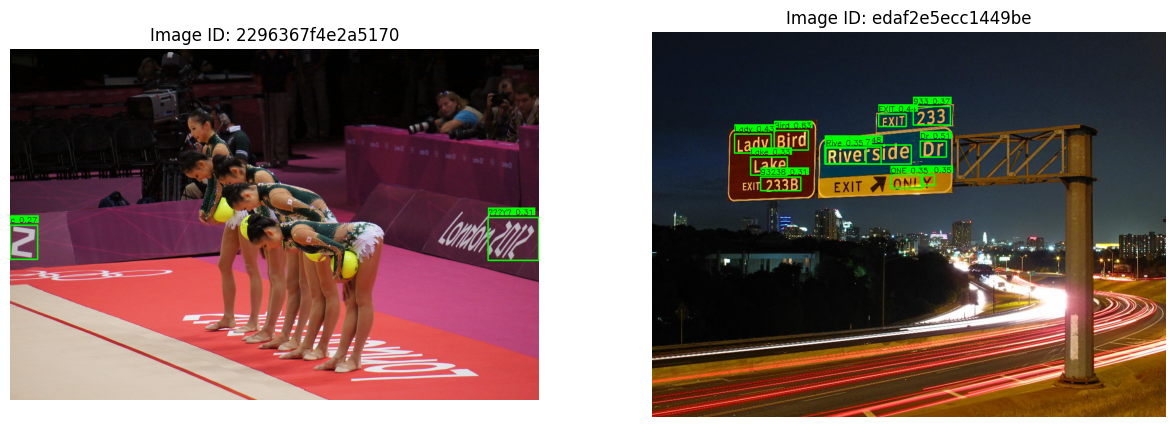


Final Results:
+------------------------------------+-------+
|               Metric               | Value |
+------------------------------------+-------+
| Overall Character Error Rate (CER) | 1.04  |
|   Overall Word Error Rate (WER)    | 1.06  |
+------------------------------------+-------+


In [56]:
NUM_SAMPLES = 2
# Set the Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\euzamuh\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# Load the trained model with the best weights
model = YOLO('runs/detect/train10/weights/best.pt')

# Define the function to draw bounding boxes and labels on the image
def draw_boxes(image, boxes, confidences, class_ids, class_names):
    extracted_texts = []
    for box, confidence, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = [int(coord) for coord in box]
        
        # Extract the region of interest (ROI) for OCR
        roi = image[y1:y2, x1:x2]
        
        # Use Tesseract to extract text from the ROI
        extracted_text = pytesseract.image_to_string(roi, config='--psm 6').strip()  # Adjust psm mode as needed
        
        label = f"{extracted_text} {confidence:.2f}"
        extracted_texts.append(extracted_text)
        
        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw the label
        font_scale = 0.5
        font = cv2.FONT_HERSHEY_SIMPLEX
        (text_width, text_height) = cv2.getTextSize(label, font, fontScale=font_scale, thickness=1)[0]
        text_offset_x = x1
        text_offset_y = y1 - 5
        box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
        cv2.rectangle(image, box_coords[0], box_coords[1], (0, 255, 0), cv2.FILLED)
        cv2.putText(image, label, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

    return image, extracted_texts

# Define the function to calculate CER and WER
def calculate_error_rates(reference, hypothesis):
    cer = editdistance.eval(reference, hypothesis) / len(reference) if len(reference) > 0 else 0
    wer = editdistance.eval(reference.split(), hypothesis.split()) / len(reference.split()) if len(reference.split()) > 0 else 0
    return cer, wer

# Define the function to perform inference, extract text, and calculate error rates for a single image
def infer_and_show(model, image_path):
    # Load the image
    image = cv2.imread(image_path)
    assert image is not None, f"Error: Unable to load image at {image_path}"

    # Perform inference
    results = model(image)
    
    # Extract the results
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding boxes in xyxy format
    confidences = results[0].boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = results[0].boxes.cls.cpu().numpy()  # Class IDs
    class_names = results[0].names  # Class names

    # Draw bounding boxes and labels on the image, and extract texts
    annotated_image, extracted_texts = draw_boxes(image, boxes, confidences, class_ids, class_names)

    # Combine extracted texts
    extracted_text_combined = " ".join(extracted_texts)

    return annotated_image, extracted_text_combined

# Define the function to process the test dataset
def process_test_dataset(model, test_ids, annot_df, num_samples=3):
    # Initialize lists to store CER and WER for each image
    cer_list = []
    wer_list = []
    images_to_display = []

    # Randomly select sample images for display
    sample_ids = random.sample(list(test_ids), num_samples)

    # Process each image in the test dataset
    for image_id in test_ids:
        img_path = os.path.join(DATA_DIR, f'{image_id}.jpg')
        reference_text = " ".join(annot_df[annot_df['image_id'] == image_id]['utf8_string'].tolist())

        # Perform inference and extract text
        annotated_image, extracted_text = infer_and_show(model, img_path)
        
        # Calculate CER and WER
        cer, wer = calculate_error_rates(reference_text, extracted_text)
        cer_list.append(cer)
        wer_list.append(wer)
        
        # Store the image to display later if it's in the sample_ids
        if image_id in sample_ids:
            images_to_display.append((annotated_image, image_id))

        # Print the extracted text and error rates for each image
        print(f"\nImage: {image_id}")
        print(f"Reference Text: {reference_text}")
        print(f"Extracted Text: {extracted_text}")
        print(f"Character Error Rate (CER): {cer:.2f}")
        print(f"Word Error Rate (WER): {wer:.2f}")
		    # Display the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for ax, (image, image_id) in zip(axes, images_to_display):
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Image ID: {image_id}")
        ax.axis('off')
    plt.show()

    # Calculate and print overall CER and WER
    overall_cer = sum(cer_list) / len(cer_list) if cer_list else 0
    overall_wer = sum(wer_list) / len(wer_list) if wer_list else 0

    # Print the final results in a table format
    headers = ["Metric", "Value"]
    results = [
        ["Overall Character Error Rate (CER)", f"{overall_cer:.2f}"],
        ["Overall Word Error Rate (WER)", f"{overall_wer:.2f}"]
    ]

    print("\nFinal Results:")
    print(tabulate(results, headers=headers, tablefmt="pretty"))

# Process the test dataset and calculate error rates
process_test_dataset(model, small_test_ids, annot_df, num_samples=NUM_SAMPLES)

In [15]:
import logging
# Set the Tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

model1 = YOLO('runs/detect/train10/weights/best.pt')

def recognize_text(model, dataset, conf_threshold=0.25):
    detected_texts = []  # Initialize list to store detected texts
    
    for img_index, (img, _) in enumerate(dataset):
        # Convert the tensor to a numpy array if necessary
        img_np = img.permute(1, 2, 0).numpy()  # Assuming img is a PyTorch tensor
        logging.info(f"Processing image {img_index} with shape: {img_np.shape}")
        
        # Perform detection using the model
        results = model(img_np)  # Call the model directly
        
        # Log the results
        logging.info(f"Image {img_index} results: {results}")

        # Check if there are detections
        if not results or len(results[0].boxes.xyxy) == 0:
            logging.warning(f"No detections for image {img_index}")
            detected_texts.append([])  # Append empty list for this image
            continue  # Skip to the next image

        # Parse the results
        bboxes = results[0].boxes.xyxy.numpy()  # Get bounding boxes (x1, y1, x2, y2)
        logging.info(f"Detected bounding boxes for image {img_index}: {bboxes}")

        texts = []
        for bbox in bboxes:  # Iterate through each detected bounding box
            text = extract_text_from_bbox(img_np, bbox)
            if text:  # Only append if text is not empty
                texts.append(text)
        
        detected_texts.append(texts)
    
    return detected_texts